In [41]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

Stokes
Solve the Stokes equations with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega \\
u &= u_{\mathrm{R}} \quad && \text{on } \Gamma_{\mathrm{R}} \\
\sigma\cdot n &= (0, 0) \quad && \text {on } \Gamma_{\mathrm{L}} \\
p &= p_{\mathrm{L}} \quad && \text {on } \Gamma_{\mathrm{L}} \\
u &= (0,0) \quad && \text{on } \Gamma_0 \\
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.

This is a model of linear (creeping) flow in the idealized case of infinitesimal (small) velocities.

We will use the following data:

* $\Omega$ defined by the mesh `dolfin_coarse.xml`

From: https://fenicsproject.org/pub/data/meshes/dolfin_coarse.xml

* $f = (0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 0\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 1\}$ (the right boundary)
* $\Gamma_{0} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$ (no-slip boundary condition)
* $p_{\mathrm{L}} = 0$ (outflow)
* $u_{\mathrm{R}} = (-\sin(\pi y), 0)$ (inflow)
* $\mu = 1$ (dynamic viscosity)


In [42]:
import requests


url = 'https://fenicsproject.org/pub/data/meshes/dolfin_coarse.xml.gz'
r = requests.get(url, allow_redirects=True)

open('dolfin_coarse.xml.gz', 'wb').write(r.content)

20702

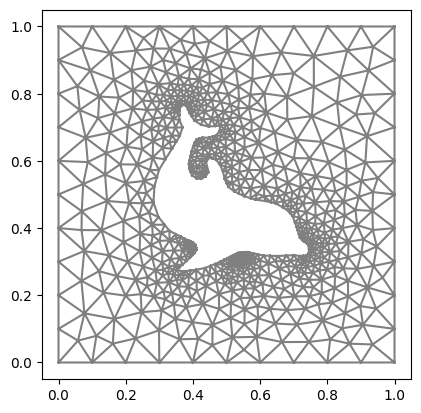

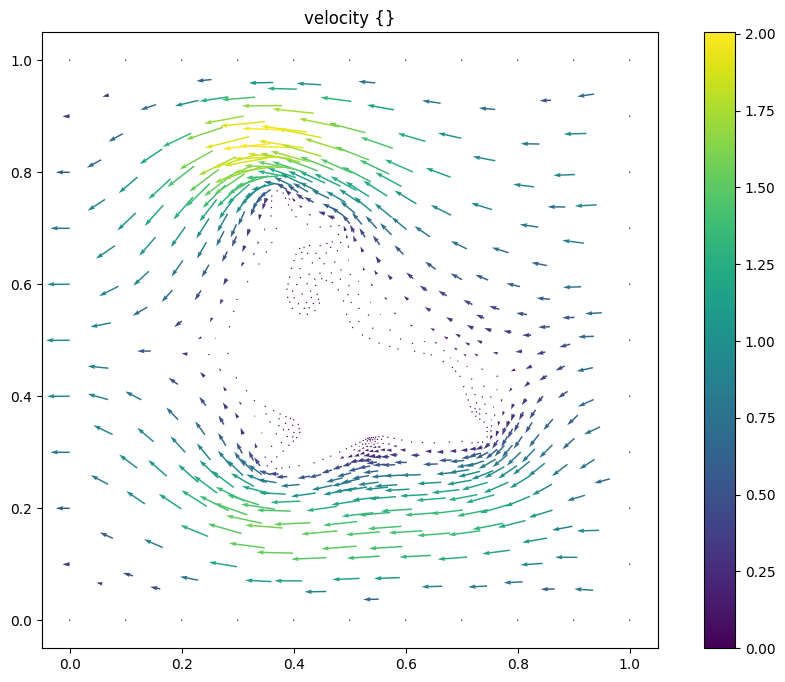

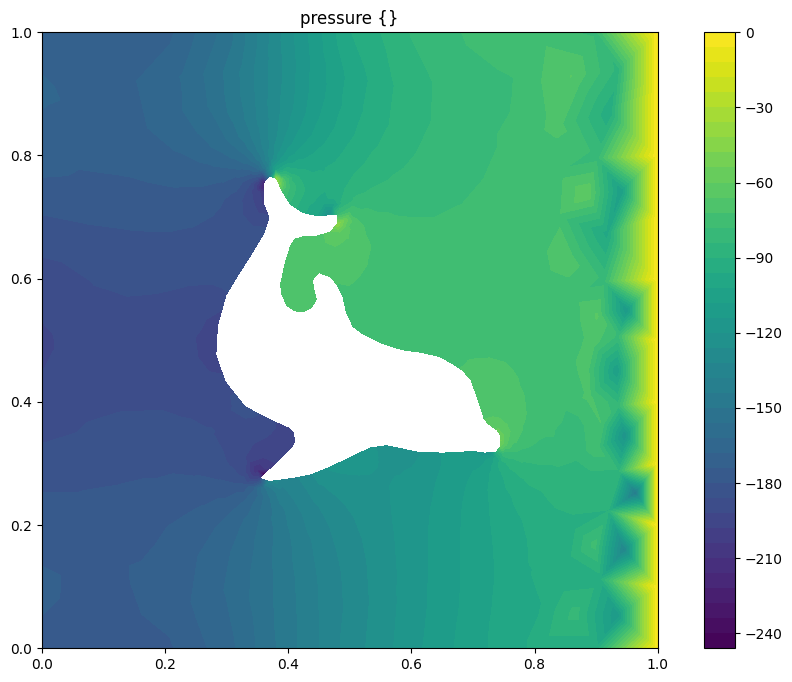

In [43]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

mesh = Mesh('dolfin_coarse.xml.gz')
plot(mesh)

# Problem data
#u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),degree=2, U=1.5)
p_L = Constant(0)
u_in = Expression(('-sin(pi*x[1])', '0.0'), degree=2)
mu = Constant(1.0)

# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
def Left( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0]) < tol)

def Right( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0] - 1) < tol)

def Top( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1] - 1) < tol)

def Bottom( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1]) < tol)


# inflow
def inflow( x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]) < tol


# outflow
def Outflow( x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]- 1) < tol

# dolphain
def Dolphain( x, on_boundary):
      tol = 1E-14
      return on_boundary and not any(b(x, on_boundary) for b in [Left, Right, Bottom, Top])


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc1 = DirichletBC(W.sub(0), (0,0), Top)
bc2 = DirichletBC(W.sub(0), (0,0), Bottom)
bc3 = DirichletBC(W.sub(0), (0,0), Left)
bc4 = DirichletBC(W.sub(0), (0,0), Right)
bc5 = DirichletBC(W.sub(0), u_in, inflow)
bc6 = DirichletBC(W.sub(1), p_L, Outflow)
bc7 = DirichletBC(W.sub(0), (0,0), Dolphain)

bcs = [bc1, bc2, bc3, bc4, bc5, bc6, bc7]

# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

## 2D Linear Elasticity: Plate with a hole subjected to axial loading

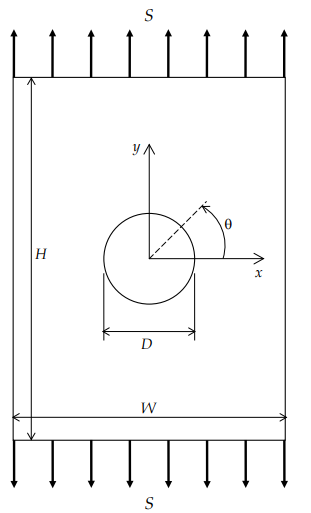


To reduce the size of each finite element model, and hence
reduce the computation times, $¼-$symmetry was utilised when creating a finite element mesh for the 2D problems.

## Problem statement

The corresponding boundary-value problem is:

$$
-\nabla \cdot \sigma = f\hbox{ in }\Omega,
$$
$$
\sigma {\bf n} = {\bf g} \text{ on } \Gamma_{top},
$$

* symmetry boundary conditions

$$
 u_y =  0 \text{ on }  \Gamma_{bottom},
$$
$$
 u_x =  0 \text{ on }  \Gamma_{left}.
$$

* Young's modulus and Poisson's ratio:

$$ E = 200.e6, \quad nu = 0.3.$$

* The load:
  1. $$f = 0$$
  2. $${\bf g} = (0,1000)$$

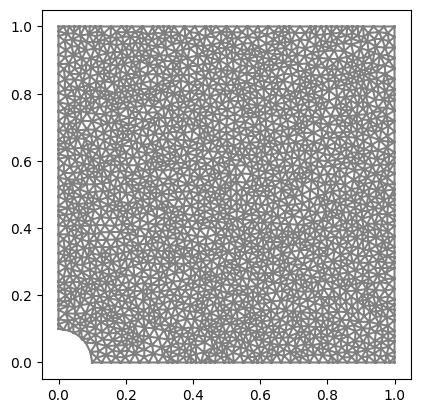

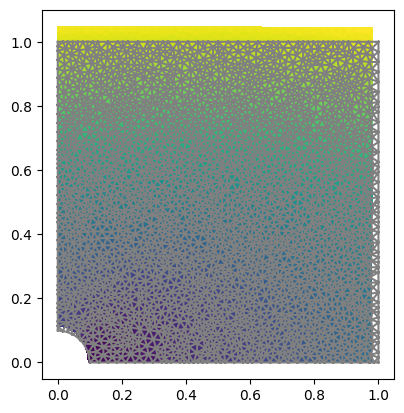

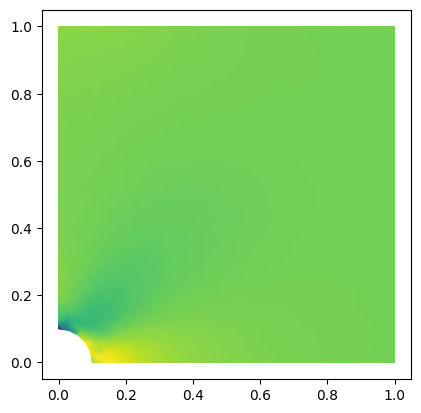

Deflection : -4.40281e-07


In [44]:
from dolfin import *
from mshr import *
%matplotlib inline
L, R = 1., 0.1
N = 40 # mesh density

domain = Rectangle(Point(0.,0.), Point(L, L)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
    return (on_boundary and near(x[1], 0.0))

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  200e6      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V.sub(1), Constant((0.0)), bottom)
bc = [bc1, bc2]
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
top = AutoSubDomain(lambda x: near(x[1], L))

top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,-rho_g))
# surface load
g = Constant((0.0, 1000.0))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()

# Beam deflection calculation
w_max = -u(L,R)[1]

print("Deflection : %g" % w_max)

Elatiscity


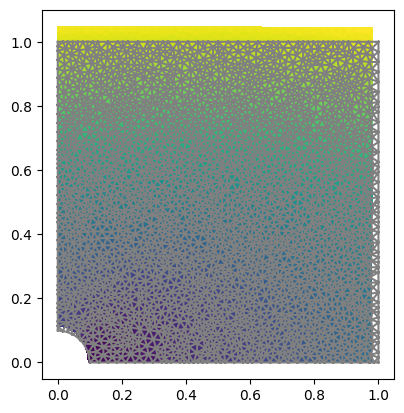

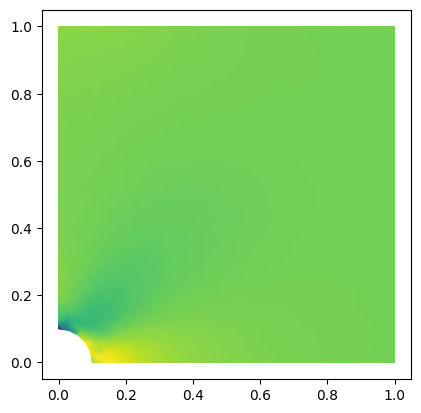

Deflection : -4.40281e-07


In [45]:
from dolfin import *
from mshr import *
%matplotlib inline
L, R = 1., 0.1
N = 40 # mesh density

domain = Rectangle(Point(0.,0.), Point(L, L)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
    return (on_boundary and near(x[1], 0.0))

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  200e6      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V.sub(1), Constant((0.0)), bottom)
bc = [bc1, bc2]
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
top = AutoSubDomain(lambda x: near(x[1], L))

top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,-rho_g))
# surface load
g = Constant((0.0, 1000.0))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()

# Beam deflection calculation
w_max = -u(L,R)[1]

print("Deflection : %g" % w_max)

A nonlinear Poisson equation

iteration  1  L2 norm of delta:   2.88e-01
iteration  2  L2 norm of delta:   5.63e-02
iteration  3  L2 norm of delta:   5.93e-02
iteration  4  L2 norm of delta:   1.45e-02
iteration  5  L2 norm of delta:   1.34e-02
iteration  6  L2 norm of delta:   4.48e-03
iteration  7  L2 norm of delta:   3.03e-03
iteration  8  L2 norm of delta:   1.40e-03
iteration  9  L2 norm of delta:   6.34e-04
iteration 10  L2 norm of delta:   4.09e-04
iteration 11  L2 norm of delta:   1.27e-04
iteration 12  L2 norm of delta:   1.11e-04
iteration 13  L2 norm of delta:   2.72e-05
iteration 14  L2 norm of delta:   2.84e-05
iteration 15  L2 norm of delta:   7.37e-06
iteration 16  L2 norm of delta:   6.80e-06
iteration 17  L2 norm of delta:   2.32e-06
iteration 18  L2 norm of delta:   1.52e-06
iteration 19  L2 norm of delta:   7.18e-07
convergence after 19 Picard iterations
L2 error:   4.66e-03   H1 error:   2.40e-01


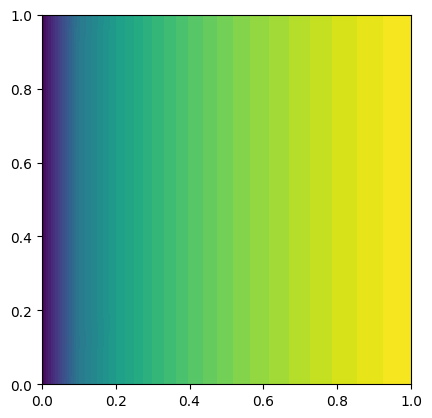

In [46]:
from dolfin import *
#
# the coefficient function
#
def q(u):
    return (1 + u)**5
#
# Create mesh and define function space
#
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, 'Lagrange', 2)
#
# Dirichlet boundary (left and right edges of the square)
#
def Gamma_d(x, on_boundary):
    return (near(x[0], 0.) or near(x[0], 1.)) and on_boundary

#
# data
#
g = Expression('x[0]', degree=1)
f = Expression('x[0]', degree=1)

bc = DirichletBC(V, g, Gamma_d)
# initial iterate:  u(x, y) = x
u0 = Expression('x[0]', degree=1)
uold = interpolate(u0, V)

# Define variational problem for Picard iteration
u = TrialFunction(V)
v = TestFunction(V)
a = q(uold) * inner(grad(u), grad(v)) * dx
L = f*v*dx
u = Function(V)

# Picard iteration
tol = 1.0E-6
maxiter = 50
#
# compute next Picard iterate
#
for iter in range(maxiter):
    solve(a == L, u, bc)
    #
    # check increment size as convergence test
    #
    eps = errornorm ( u, uold, 'L2' )
    print('iteration{:3d}  L2 norm of delta: {:10.2e}'.format(iter+1, eps))
    if eps < tol:
        break
    uold.assign(u)

if eps > tol:
    print('no convergence after {} Picard iterations'.format(iter+1))
else:
    print('convergence after {} Picard iterations'.format(iter+1))
#
# use the exact solution to compute the error
#
uexp = Expression('pow(63.*x[0] + 1, 1./6.) - 1.', degree=6)
Vf = FunctionSpace(mesh, 'Lagrange', 4)
uex = interpolate(uexp, Vf)
uh=interpolate(u, Vf)
#
# L2 norm
#
L2norm = errornorm ( uex, uh, 'L2' )
#
# H1seminorm
#
H1seminorm = errornorm ( uex, uh, 'H10' )
print('L2 error: {:10.2e}   H1 error: {:10.2e}'.format(L2norm, H1seminorm))

plot(u)

Time-dependent Heat or Diffusion Equation PDE

### Concrete example:

We choose a simple 2D domain: the unit square $\Omega = [0,1] \times [0,1]$ .

In order to compare the finite element solution to the exact solution, here we construct a model problem with the exact solution:

\begin{equation} u_{ex}(x,y,t) =1 + x^2 + \alpha y^2 + \beta t,. \end{equation}

If we substitute this exact solution ${u_{ex}}$ into heat equation we find that $f$ is:

\begin{equation} f(x,y,t) = \beta - 2 - 2\alpha. \end{equation}

The boundary condition is :

\begin{equation}{u_D}(x,y) = 1 + x^2 + \alpha y^2 + \beta t, \end{equation}

and the initial value is obtained at $t = 0$:
$$u_0(x, y) = 1 + x^2 + \alpha y^2.$$

t = 0.20: error = 3.11e-15
t = 0.40: error = 2.22e-15
t = 0.60: error = 2.66e-15
t = 0.80: error = 4e-15
t = 1.00: error = 4e-15
t = 1.20: error = 4e-15
t = 1.40: error = 4.44e-15
t = 1.60: error = 4.88e-15
t = 1.80: error = 3.55e-15
t = 2.00: error = 4.44e-15


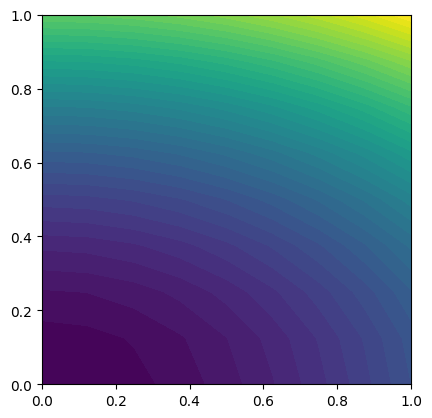

In [47]:
from dolfin import *
import numpy as np
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
plot(mesh)

# Define the finite element space
V = FunctionSpace(mesh, 'P', 1)

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

alpha = 3; beta = 1.2
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

f = Constant(beta - 2 - 2*alpha)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Compute and Plot the initial solution
u_k = interpolate(u_D, V)

plot(u_k)

u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dot(grad(u), grad(v))*dx

L =  (u_k + dt*f)*v*dx

u = Function(V)
t = 0

for k in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Solve variational problem
    solve(a == L, u, bc)

    # Compute maximum error at vertices

    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
    print('t = %.2f: error = %.3g' % (t, error_max))

    # Update previous solution

    u_k.assign(u)

plot(u_k)

**Example:**

Consider 2D heat transfer across a plate  of thermal conductivity $\kappa = 0.935 W/mC $ shown in the figure below

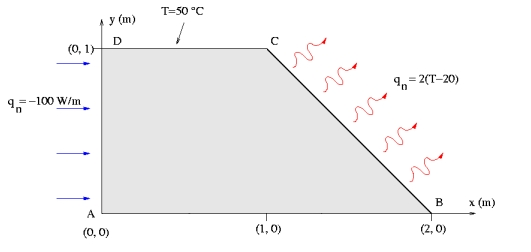

The temperature of the top side of the plate is 50º C and the bottom part is isolated. The heating source is applied at left part of the domain.  Convection constraint is applied at right part of the plate with  heat transfer coefficient of $h = 2 W/m^2ºC$, being $T_0 = 20ºC$ the ambient temperature of the fluid around the plate.

**Solution:**

Governing Equation for Heat Transfer Derived from
Fourier’s law:

\begin{alignat}{2}
{\partial T\over\partial t} &= \nabla.(\kappa \nabla T) + f \quad &&\hbox{in }\Omega\times(0, t_f], \tag{1}
\end{alignat}

We define the heat flux boundary conditions:

\begin{alignat}{2}
-\kappa{\partial T\over\partial n} &= -100 W/m \quad&&\mbox{on } (DA),\quad \tag{2}\\
-\kappa{\partial T\over\partial n} &= 2(T-20) \quad&&\mbox{on } (BC),\quad \tag{3}\\
-\kappa{\partial T\over\partial n} &= 0 \quad&&\mbox{on } (AB),\quad \tag{4}
\end{alignat}

Dirichlet boundary condition:
$$  
T = 50, \quad \mbox{on } (CD),\quad \tag{5}$$
Initial condition:
$$ T = 20, \mbox{  at } t=0. \tag{6}$$



 number of cells =  913


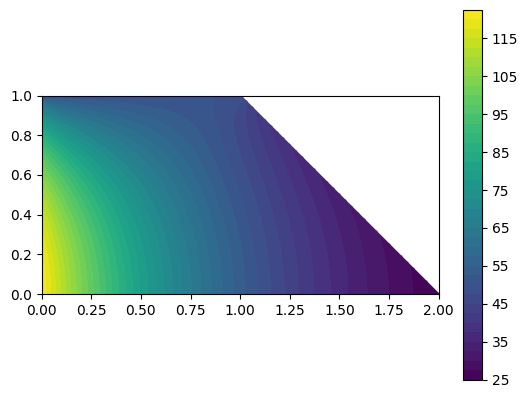

In [48]:
from dolfin import *
from mshr import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
#n = 10
#d = 1
#mesh = RectangleMesh(Point(0, 0), Point(1, 1), n, n)
#plot(mesh)

print (" number of cells = ",mesh.num_cells())
plot(mesh)

V = FunctionSpace(mesh, 'P', 1)

# Set the boundary conditions bc
def top(x, on_boundary):
  return near(x[1],1.0)

u_D = Constant(50.)

bc = DirichletBC(V, u_D, top)

# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[0], 0.0)

class Right(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1]+x[0]-2.0, 0.0)

class Bottom(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], 0.0)

# Initialize sub-domain instances
left = Left()
right = Right()
bottom = Bottom()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

left.mark(boundaries, 1)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

f = Constant(0.)
g1 = Constant(-100.)
g4  = Constant(0.)
h = Constant(2.0)
u_0 = Constant(20.0)
kappa = Constant(0.935)

# Define input data
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

T_0 = Constant(20.0)
u_k = interpolate(T_0, V)

u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*kappa*dot(grad(u), grad(v))*dx + dt*h*u*v*ds(3)
L =  (u_k + dt*f)*v*dx - dt*g1*v*ds(1) - dt*g4*v*ds(4) + dt*h*u_0*v*ds(3)

uh = Function(V)
t=0

for k in range(num_steps):
  # Update current time
  t += dt
  #u_D.t = t
  #f.t = t ##updating f if f depending on t
  # Solve variational problem
  solve(a==L, uh, bc)
  #FE solution
  vertex_values_u = uh.compute_vertex_values(mesh)
  # Update previous solution
  u_k.assign(uh)

p = plot(u_k)
plt.colorbar(p)

Standard second-order partial differential equation in two variables

Number of dofs 625


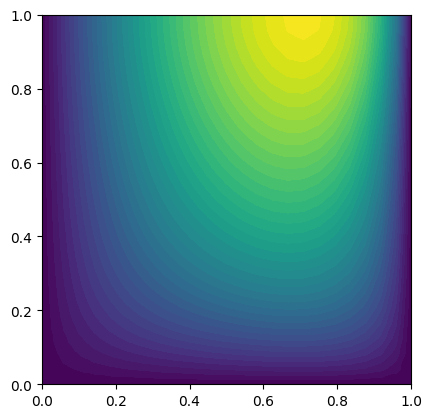

In [49]:
# Import FEniCS
from fenics import *
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

n = 24
d = 1

mesh = UnitSquareMesh(n, n)

Vh = FunctionSpace(mesh, "Lagrange", d)
print("Number of dofs", Vh.dim())

def boundary_d(x, on_boundary):
    return (x[1] < DOLFIN_EPS or x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS) and on_boundary

u_d  = Constant(0.)
bcs = [DirichletBC(Vh, u_d, boundary_d)]

uh = TrialFunction(Vh)
vh = TestFunction(Vh)

k = Expression("exp(-x[0]*x[0] -x[1]*x[1])", degree = d+2)
w = Constant( (1.,0.))
c = Constant(1.)

f = Constant(1.)
g = Constant(0.)
a = k*inner(grad(uh), grad(vh))*dx + dot(w, grad(uh))*vh*dx + c*uh*vh*dx
L =  f*vh*dx + g*vh*ds

A, b = assemble_system(a, L, bcs) # to get A as Matrix
uh = Function(Vh)
solve(A, uh.vector(), b) # be careful

plot(uh, mytitle="Finite Element Solution")
plt.show()


Explicit time-discretization of the heat equation

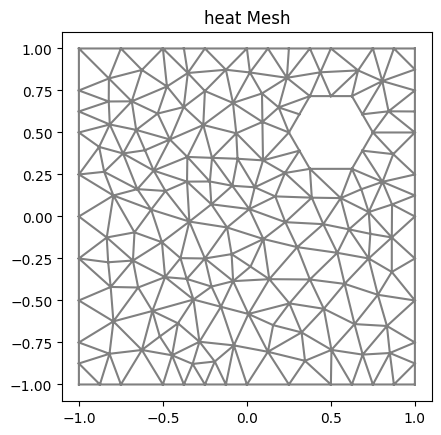

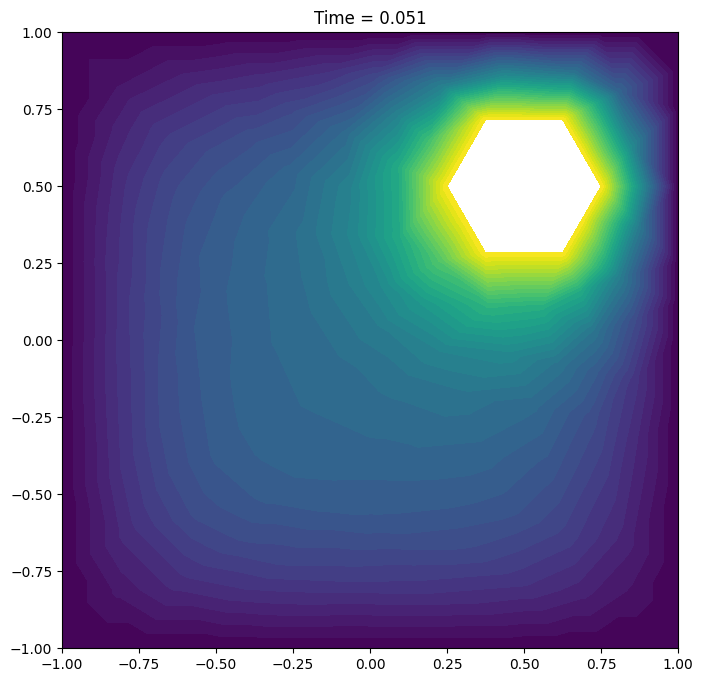

In [50]:
#
from dolfin import *
from mshr import *
#
import matplotlib.pyplot as plt
# heat_explicit
#
#  Define the domain.
#
r_x = 0.5
r_y = 0.5
r_r = 0.25
domain = Rectangle(Point(-1.,-1.), Point(1.,1.)) - Circle(Point(r_x,r_y),r_r)
#
#  Mesh the domain.
#
mesh = generate_mesh ( domain, 10 )
#
#  Plot the mesh.
#
plot ( mesh, title = 'heat Mesh' )

#
#  Define the function space.
#
V = FunctionSpace ( mesh, "Lagrange", 1 )
#
#  Define the boundary conditions.
#
Tol = DOLFIN_EPS
u_D1 = 10.0
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
      return ( on_boundary and ( (abs( x[0]-1.0 ) < Tol) or
                               (abs( x[0]+1.0 ) < Tol) or
                               (abs( x[1]-1.0 ) < Tol) or
                               (abs( x[1]+1.0 ) < Tol) ) )
ext = Bottom()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

bc1 = DirichletBC ( V, u_D1, ext )

u_D2 = 100.0

def inter ( x, on_boundary ):
    r = sqrt ( ( x[0] - r_x ) ** 2 + ( x[1] - r_y ) ** 2 )
    return ( on_boundary and ( r < r_r * 1.1 ) )

bc2 = DirichletBC ( V, u_D2, inter )
#
bc = [bc1, bc2 ]
#

#
#  The trial functions (u) and test functions (v).
#
u = TrialFunction ( V )
v = TestFunction ( V )
uold = Function ( V )  #  UOLD must be a Function.
#
#  Define the bilinear form.
#
a = inner ( u, v ) * dx
#
#  The diffusivity is a constant.
#
k = Constant ( 1.0 )
f = Expression ( "0.0", degree = 3 )
#
#  Define time
#
t_init = 0.0   #  The initial time.
t_final = 0.05 #  The final time.
t_num = 50     #  The number of step.
dt = ( t_final - t_init ) / t_num   #  The step size.
#
#  The initial condition
#
u_init = Expression ( "40.0", degree = 3 )
u = interpolate ( u_init, V )
#
#  The initial time.
#
t = t_init
#
#  Time loop.
#
for j in range ( 0, t_num + 1 ):
#
#  Update UOLD
#
    uold.assign ( u )
#
#  Update  the right hand side.
#
    L = inner ( uold, v ) * dx - dt * k * inner ( grad ( uold ), grad ( v ) ) * dx + dt * inner ( f, v ) * dx
#
#  Solution of the variational problem a(u,v) = L(v).
#
    solve ( a == L, u, bc )
#
#  Update  the time
#
    t = t + dt
# plot solution of the last step
plt.figure(figsize=(12,8))
label = 'Time = %g' % ( t )
plot(u,title = label)

Implicit time-discretization of the heat equation

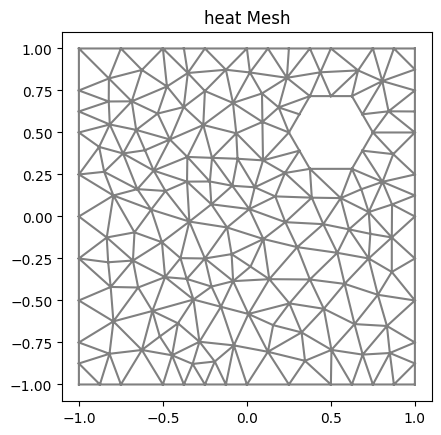

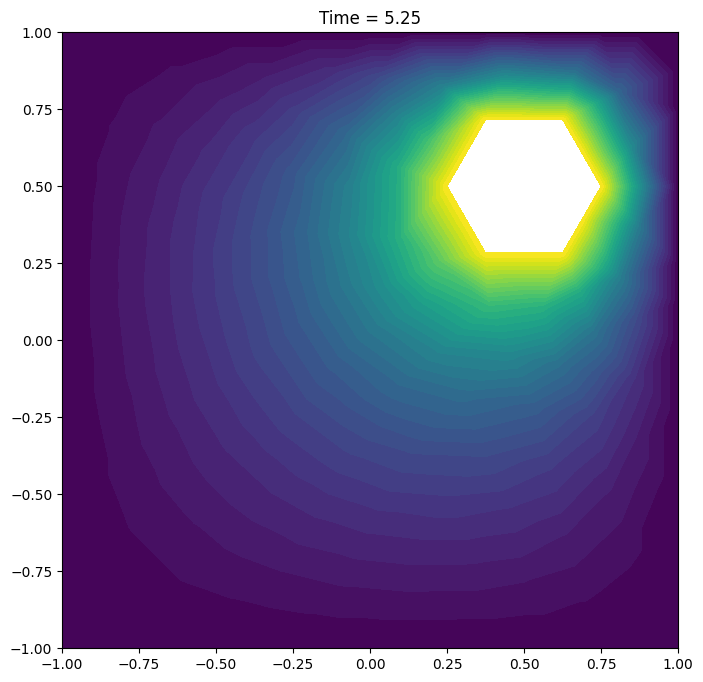

In [51]:
from dolfin import *
from mshr import *
#
# heat_implicit
#
import matplotlib.pyplot as plt
#
#  Define the domain.
#
r_x = 0.5
r_y = 0.5
r_r = 0.25
#
domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.)) - Circle(Point(r_x,r_y),r_r)
#
#  Mesh the domain.
#
mesh = generate_mesh ( domain, 10 )
#
#  Plot the mesh.
#
plot ( mesh, title = 'heat Mesh' )
#
#  Define the function space.
#
V = FunctionSpace ( mesh, "Lagrange", 1 )
#
#  Define the boundary conditions.
#
Tol = DOLFIN_EPS
u_D1 = 10.0
#
def ext ( x, on_boundary ):
    return ( on_boundary and ( (abs( x[0]-1.0 ) < Tol) or
                              (abs( x[0]+1.0 ) < Tol) or
                              (abs( x[1]-1.0 ) < Tol) or
                              (abs( x[1]+1.0 ) < Tol) ) )
#
bc1 = DirichletBC ( V, u_D1, ext )
#
u_D2 = 100.0
#
def inter ( x, on_boundary ):
    r = sqrt ( ( x[0] - r_x ) ** 2 + ( x[1] - r_y ) ** 2 )
    return ( on_boundary and ( r < r_r * 1.1 ) )
#
bc2 = DirichletBC ( V, u_D2, inter )
#
bc = [bc1, bc2 ]
#
#  The data
#
k = Constant ( 1.0 )
f = Constant ( 0.0 )
#
#  Define time
#
t_init = 0.0  #  The initial time.
t_final = 5.0 #  The final time.
t_num = 20    #  The number of step
dt = ( t_final - t_init ) / t_num  # The step size
#
#  The initial condition
#
u_init = Expression ( "40.0", degree = 10 )
u_old = interpolate ( u_init, V )
#
#  Define the bilinear form and the linear form..
#  Define the trial functions (u) and test functions (v).
#
u = TrialFunction ( V )
v = TestFunction ( V )
L = ( u_old + dt * f ) * v * dx
a = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
#
u = Function ( V )
#
#  The initial time.
#
t = t_init
#
#  Time loop.
#
for j in range ( 0, t_num + 1 ):
#
#  Update  the time
#
    t = t + dt
#
#  Solution of the variational problem a(u,v) = L(v).
#
    solve ( a == L, u, bc )
#
#  #  Update  U_OLD
#
    u_old.assign ( u )
#
# plot solution of the last stesp
#
plt.figure(figsize=(12,8))
label = 'Time = %g' % ( t )
plot(u,title = label)

#  Standard second-order partial differential equation in two variables
Advection-Diffusion-Reaction PDEs

Modify the previous code to solve the following the boundary value problem:

\begin{eqnarray*}
-  \text{ div }(\mathbf k \mathbf{\nabla} u)  = f, &      \text{ in } &\Omega,   \tag{1}\\
u = u_0, & \text{ on } & \Gamma_D = \Gamma_{left} \cup \Gamma_{right}, \tag{2}\\
\frac{\partial u}{\partial {n}} = g, & \text{ on } &\Gamma_N = \Gamma_{top} \cup \Gamma_{bottom} , \tag{3}
\end{eqnarray*}

with
$$
\Omega = (0,1)^2,
$$

\begin{eqnarray*}
{\mathbf k}(x,y) = \bigg( \begin{array}{l} 2 & 1 \\ 1  & 2\end{array} \bigg ),
\end{eqnarray*}

$$ f(x, y) = 10 e^{-((x - 0.5)^2 + (y - 0.5)^2) / 0.02} $$
$$
u_\mathrm{0}(x, y) = 0,
$$
\begin{eqnarray*}
g(x, y) = sin(5x).
\end{eqnarray*}

The following script can be used to implement the thermal conductivity:
```
#
# Define thermal conductivity
#
k = as_matrix([[2.0 , 1.0] , [1.0 , 2.0]])
#
# Define variational problem
#
v = TestFunction(V)
u = TrialFunction(V)
a = inner(k*grad(u), grad(v))*dx
```

### Solution

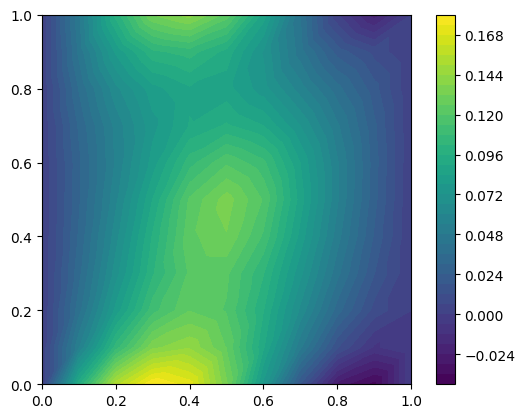

In [52]:
from fenics import *
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

# Create mesh and define function space
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "CG", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x, on_boundary):
    return (on_boundary and x[0] < DOLFIN_EPS) or (on_boundary and x[0] > 1.0 - DOLFIN_EPS)

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define the Top part of the boundary
class T_Boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and abs(x[1] - 1) < DOLFIN_EPS)

# Define the Top part of the boundary
class B_Boundary(SubDomain):
    def inside(self, x, on_boundary):
        return  (on_boundary and abs(x[1]) < DOLFIN_EPS)

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0
boundary_parts.set_all(0)

# Mark the boundaries as subdomains  1, 2, 3 and 4

Gamma_top = T_Boundary()
Gamma_top.mark(boundary_parts, 1)

Gamma_Bot = B_Boundary()
Gamma_Bot.mark(boundary_parts, 2)
# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

# Define variational problem
A = as_matrix([[2.0 , 1.0] , [1.0 , 2.0]])
v = TestFunction(V)
u = TrialFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=3)
g = Expression("sin(5*x[0])", degree=3)
a = inner(A*grad(u), grad(v))*dx
L = f*v*dx + g*v*ds(1)+ g*v*ds(2)

U = Function(V)

# Assemble the left- and right-hand sides of the variational formulation:
# assembling the coefficient matrix A and the right-hand side vector b of
# the linear system

A = assemble(a)
b = assemble(L)
x = U.vector()

# Apply boundary conditions
bc.apply(A, b)

# Specify the solver method
solver = KrylovSolver()

# Solve linear system
solver.solve(A, x, b)


# Plot solution
p=plot(U, interactive=True)
plt.colorbar(p)
plt.show()

**Example:**

Consider 2D heat transfer across a plate  of thermal conductivity $\kappa = 0.935 W/mºC $ shown in the figure below

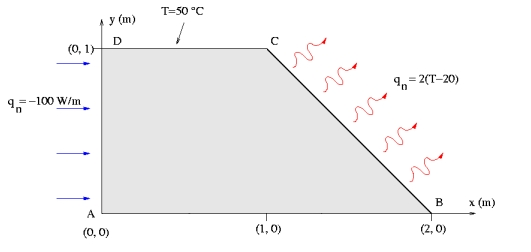

The temperature of the top side of the plate is 50º C and the bottom part is isolated. The heating source is applied at left part of the domain.  Convection constraint is applied at right part of the plate with  heat transfer coefficient of $h = 2 W/m^2ºC$, being $T_0 = 20ºC$ the ambient temperature of the fluid around the plate.

Governing Equation for Heat Transfer Derived from
Fourier’s law:

\begin{alignat}{2}
 - \nabla.(\kappa \nabla u) &=  f \quad &&\hbox{in }\Omega, \tag{1}
\end{alignat}

We define the heat flux boundary conditions:

\begin{alignat}{2}
-\kappa{\partial u\over\partial n} &= -100 W/mm \quad&&\mbox{on } (DA),\quad \tag{2}\\
-\kappa{\partial u\over\partial n} &= 2(T-20) \quad&&\mbox{on } (BC),\quad \tag{3}\\
-\kappa{\partial u\over\partial n} &= 0 \quad&&\mbox{on } (AB),\quad \tag{4}
\end{alignat}

Dirichlet boundary condition:
$$  
u = 50, \quad \mbox{on } (CD),\quad \tag{5}$$
The load:
$$f = 2xy, \quad \mbox{in }\Omega,\quad \tag{6}$$


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1d75b2aa4518d05a599e6dae500093ecea25098e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 5
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              5
  Coefficients:                        '[f_7692, f_7693, f_7694, f_7695, f_7696]'
  Unique elements:              

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_aeedf192a827788ec5355650db3824376d9d7076

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 3
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_7690, f_7692]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadratur

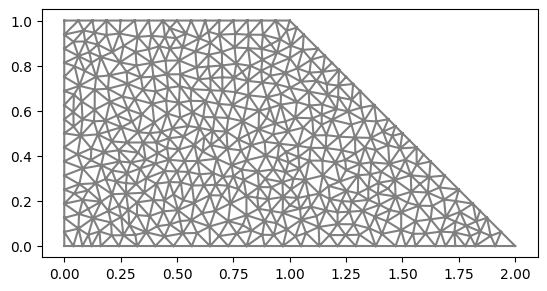

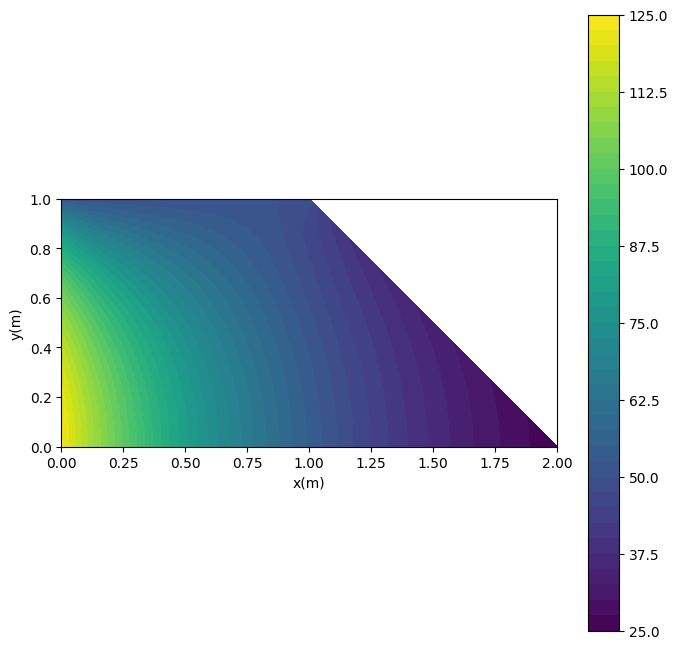

In [53]:
from dolfin import *
from mshr import *
import numpy
%matplotlib inline
import matplotlib.pyplot as plt

# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
#
plot(mesh)
#
#  Define the function space.
#
Vh  = FunctionSpace(mesh, 'Lagrange', 1)
#
# Data
#
k = Constant(0.935)
u_f = Constant(50.)
h = Constant(2.)
T0 = Constant(20.)
g_a = Constant(0.)
g_b = Constant(100.)
f = Expression('2*x[0]*x[1]', degree=2)

#  Define  the boundaries
#
# Define the Left part of the boundary  (x = 0 )
#
class left(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[0]) < DOLFIN_EPS
#
# Define the Right part of the boundary ( x + y = 2)
#
class right(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1]+x[0]-2.0, 0.0)
#
# Define the Bottom part of the boundary  (y = 0 )
#
class bottom(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and abs(x[1]) < DOLFIN_EPS
#
# Define the Top part of the boundary ( y = 1)
#
def top ( x, on_boundary ):
  return on_boundary and abs(x[1] - 1) < DOLFIN_EPS
#
#   Mark the different parts of the boundary:
#
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#
# mark the entire boundary as 0
boundary_parts.set_all(0)
#
# Mark the boundaries as subdomains  1, 2 and 4
#
#    Bottom part of the boundary
#
Bottom_p = bottom()
Bottom_p.mark(boundary_parts, 1)
#
#    Left part of the boundary
#
Left_p = left()
Left_p.mark(boundary_parts, 4)
#
#    Right part of the boundary
#
Right_p = right()
Right_p.mark(boundary_parts, 2)

#
#   Dirichlet boundary condition:
#
bcs = [DirichletBC(Vh, u_f, top)]
#
# Define the integration on boundary
#
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

u = TrialFunction(Vh)
v = TestFunction(Vh)
a =  k * inner(nabla_grad(u), nabla_grad(v))*dx +  h * u * v *ds(2)
b = f*v*dx + g_a*v*ds(1) + g_b*v*ds(4) + h * T0 * v *ds(2)

u = Function ( Vh )

solve ( a == b, u, bcs )
#
# plot the solution at each step
#
plt.figure(figsize=(8,8))
p = plot(u)
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar(p)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0caa1490b87de9c0ccb776dd2463cd8c11bf8a1f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 2
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              3
  Coefficients:                        '[f_7714, f_7715, f_7737]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5c8242ea957d9233cf7ddc636e0ce420dbc4e98e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 2
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_7713, f_7714]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadratur

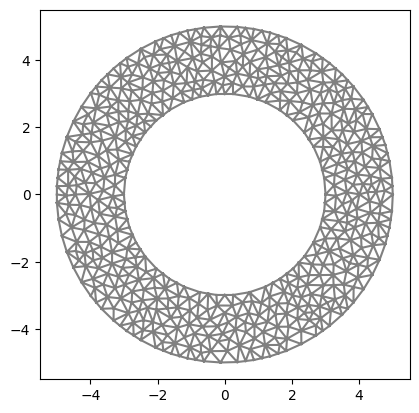

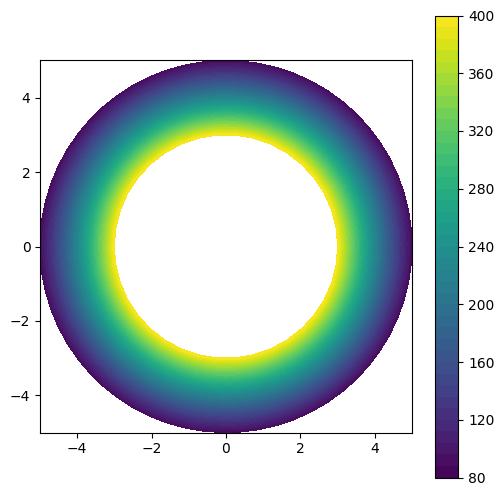

In [54]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

#
%matplotlib inline
r_ex = 5.0
r_in = 3.0

k = Constant(0.935) #conductivity
h = Constant(2.)
T0 = Constant(30.)

domain = Circle(Point(0,0),r_ex)- Circle(Point(0,0),r_in)

#
mesh = generate_mesh(domain, 20)
plot(mesh)

V = FunctionSpace(mesh, 'P', 1)

#  Use the expression to define the boundary condition.
def circle_intern(x, on_boundary):
  r = sqrt(x[0]*x[0]+x[1]*x[1])
  return on_boundary and r < r_in*1.1

u1 = Constant(400.)
bc1 = DirichletBC(V, u1, circle_intern)

class circle_extern(SubDomain):
  def inside(self, x, on_boundary):
    r1 = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r1 > r_ex*0.9

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary_parts.set_all(0)

Circle_extern = circle_extern()
Circle_extern.mark(boundary_parts, 1)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

# A list of boundary conditions for solve
bcs = [bc1]
#
#  Define the variational problem.
#
u = TrialFunction ( V )
v = TestFunction ( V )
#
f = Constant(0.0)
#
a = k*inner(nabla_grad(u), nabla_grad(v))*dx + h*u*v*ds(1)
L = f*v*dx + h*T0*v*ds(1)
#
#  Compute the solution.
#
uh = Function(V)
solve ( a == L, uh, bcs)


plt.figure(figsize=(6,6))
p = plot(uh)
plt.colorbar(p)
plt.show()

Solve the following boundary value problem:

\begin{eqnarray*}
- k \Delta T  =  f &    \text{ in } &\Omega,   \tag{4}\\
T = T_T, & \text{ on } & \Gamma_{top}, \tag{5}\\
T = T_B, & \text{ on } & \Gamma_{bottom}, \tag{6}\\
T = T_R, & \text{ on } &\Gamma_{right}  , \tag{7}\\
T = T_L, & \text{ on } &\Gamma_{left} , \tag{8}\\
T = T_{int}, & \text{ on } &\Gamma_{int}= \{(x,y)\in {\bf R}^2, x^2 + y^2 = 1/4 \}, \tag{9}
\end{eqnarray*}

with:
$$\Omega = [-1, 1] \times [-1, 1] - \{(x,y)\in {\bf R}^2, x^2 + y^2 < 1/4 \},$$


$$
k(x,y)=1,
$$

$$ f(x, y) = 10 e^{-((x - 0.5)^2 + (y - 0.5)^2) / 0.02} $$

and Dirichlet boundary conditions:
$$
T(x, y) = \begin{cases}
T_T = 300.0, & \text{ on } \Gamma_{top},\\
T_B = 300.0, & \text{ on } \Gamma_{bottom},\\
T_R = 300.0, & \text{ on } \Gamma_{right},\\
T_L = 300.0, & \text{ on } \Gamma_{left},\\
T_{int} = 400.0, & \text{ on } \Gamma_{int},
\end{cases},
$$

* The domain $\Omega$ is shown below::

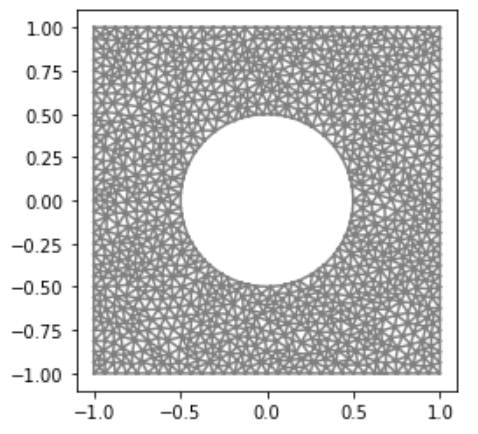

$$ f(x, y) = 10 e^{-((x - 0.5)^2 + (y - 0.5)^2) / 0.02} $$

dim(Vh) =  538
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bbce93efb43abcde901deb3d245018ce57a35050

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 2
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              2
  Coefficients:                        '[f_7737, f_7776]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rul

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a336142d1df4fe001228e83c631705beca64536e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0369129 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

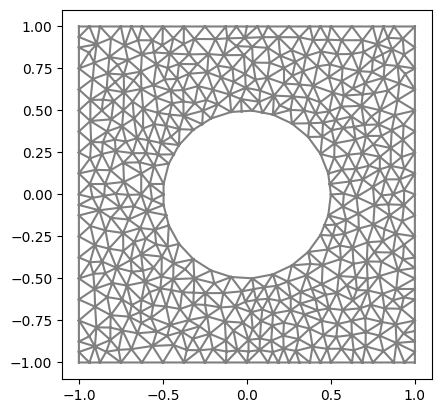

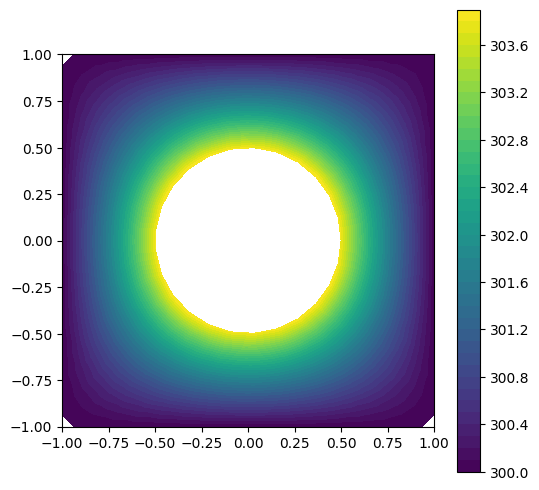

In [55]:
from dolfin import *
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline


from mshr import *
n = 10
d = 1

domain = Rectangle(Point(-1, -1), Point(1, 1)) - Circle(Point(0,0),0.5)

#
mesh = generate_mesh(domain, 20)
plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())

#
#  Neumann boundary condition
#
class circle_intern(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r < 0.5*1.1

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0

boundary_parts.set_all(0)

# Mark the boundary as subdomain  1
Gamma_int = circle_intern()
Gamma_int.mark(boundary_parts, 1)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

#
#  Define Dirichlet boundary conditions
#
def top(x, on_boundary):
  return on_boundary and near(x[1], 1.0)

u2 = Constant(300.)
bc2 = DirichletBC(Vh, u2, top)

def bot(x, on_boundary):
  return on_boundary and near(x[1], -1.0)

bc3 = DirichletBC(Vh, u2, bot)


def right(x, on_boundary):
  return on_boundary and near(x[0], 1.0)

bc4 = DirichletBC(Vh, u2, right)

def left(x, on_boundary):
  return on_boundary and near(x[0], -1.0)

bc5 = DirichletBC(Vh, u2, left)
# A list of boundary conditions for solve
bcs = [bc2, bc3,bc4,bc5]

#
#    Surface load
#
g = Constant(10.)
#
#  Define the variational problem.
#
u = TrialFunction ( Vh )
v = TestFunction ( Vh )

#
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx + g*v*ds(1)
#
#  Compute the solution.
#
uh = Function(Vh)
solve ( a == L, uh, bcs)


plt.figure(figsize=(6,6))
p = plot(uh)
plt.colorbar(p)
plt.show()

**Modify the previous code to solve the following the problem:**

Consider 2D heat transfer across a plate  of thermal conductivity $k = 50 $ shown in the figure below

\begin{align}
-k\Delta u & = f, & \mbox{ in } & \Omega\\
u & = T_0, & \mbox{ on sides: } & AB \cup CD \cup EF \cup GH\\
k \nabla T \cdot {\bf n}  & = g, & \mbox{  on sides: } & BC \cup DE \cup FG \cup HA  
\end{align}
where
$$f(x,y) = x^2 + y^2,$$
$$T_0 = 350,$$
$$g(x,y) = 100.$$


dim(Vh) =  4871
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3714f9b14aca40931d087834bf477a0f0c4c8e7d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 5
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              2
  Coefficients:                        '[f_7826, f_7827]'
  Unique elements:                     'CG1(?,?), R0(?,?), CG3(?,?), Vector<2 x CG1(
                                       ?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), CG3(?,?), Vector<2 x CG1(
                    

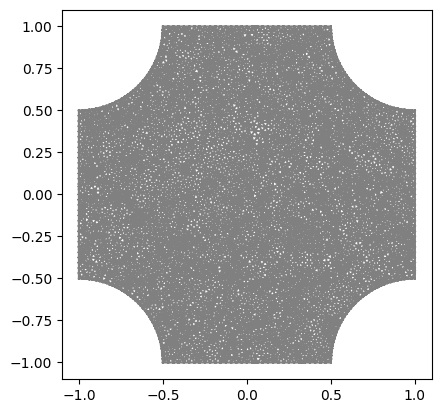

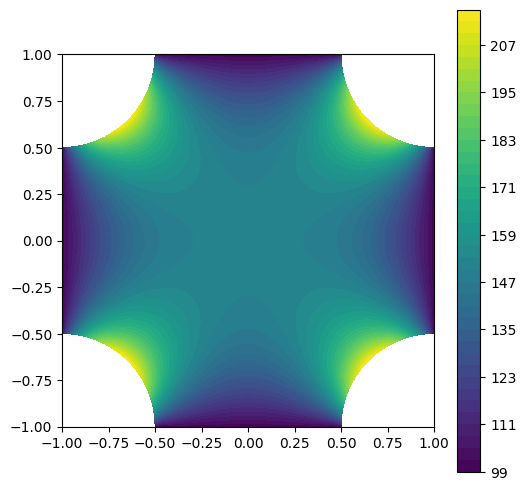

In [56]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
#
%matplotlib inline
A = Point ( -1.0, -1.0 )
B = Point ( 1.0, 1.0 )
radius = 0.5

domain = Rectangle(A,B) - Circle(Point(1,1),radius) - Circle(Point(-1,1),radius) -\
                           Circle(Point(-1,-1),radius) - Circle(Point(1,-1),radius)

mesh = generate_mesh (domain ,50)
plot(mesh)
#
d = 1
Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())
#
k = Constant(50.)
T0 = Constant(100.0)
g   = Constant(350.) # gamma boundary

f = Expression('x[0]*x[0] + x[1]*x[1]', degree=d+2)
#
#  Define Dirichlet boundary condition
#
def TopBoundary(x, on_boundary):
  return on_boundary and near(x[1] , 1)

bc_1 = DirichletBC(Vh, T0, TopBoundary)
#
def BottomBoundary(x, on_boundary):
  return on_boundary and near(x[1] , -1)

bc_2 = DirichletBC(Vh, T0, BottomBoundary)
#
def LeftBoundary(x, on_boundary):
  return on_boundary and near(x[0] , -1)

bc_3 = DirichletBC(Vh, T0, LeftBoundary)
#
def RightBoundary(x, on_boundary):
  return on_boundary and near(x[0] ,1)

bc_4 = DirichletBC(Vh, T0, RightBoundary)
#
bcs = [bc_1, bc_2, bc_3, bc_4]
#
# Define boundary labels
#
class Top_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] -1)**2 + (x[1] - 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Top_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +1)**2 + (x[1] - 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Bottom_left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +1 )**2 + (x[1] + 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

class Bottom_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] - 1)**2 + (x[1] + 1)**2)
    return (on_boundary) and (r < radius * 1.0001)

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
# mark the entire boundary as 0
boundary_parts.set_all(0)

# Mark the boundaries as subdomains  1, 2, 3 and 4
top_right_hole = Top_Right_hole()
top_right_hole.mark(boundary_parts, 1)

top_Left_hole = Top_Left_hole()
top_Left_hole.mark(boundary_parts, 2)

bottom_left_hole = Bottom_left_hole()
bottom_left_hole.mark(boundary_parts, 3)

bottom_Right_hole = Bottom_Right_hole()
bottom_Right_hole.mark(boundary_parts, 4)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)
#
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx + g*v*ds(1) + g*v*ds(2) + g*v*ds(3) +  g*v*ds(4)
#
uh = Function(Vh)
solve(a == L, uh, bcs=bcs)
#
# Plot solution
plt.figure(figsize=(6,6))
p=plot(uh)
plt.colorbar(p)
plt.show()

**Modify the previous code to solve the following the problem:**

Consider 2D heat transfer across the domain shown in the figure below:

\begin{eqnarray*}
- k(x,y) \Delta T(x,y)  = f(x,y), &   \quad\text{ in }   \Omega = (-6,6)^2, &  \tag{1}\\
T = T_0 = \left\{
\begin{split}
 \quad  &  295 K, & \quad \text{  on the left side: x = -6}\\
 \quad  &  375 K, & \quad \text{  on the right side: x = 6}
\end{split}
\right.  , & \text{ Dirichlet boundary condition } &  \tag{2}\\
k \nabla T \cdot {\bf n} = g= \left\{
\begin{split}
 \quad  &  0, & \quad \text{ on the bottom side: y = -6}\\
 \quad  &  10 W/m, & \quad \text{ on the top side: y = 6}
\end{split}
\right.  , &  \text{ Neumann boundary condition  }&\tag{3}
\end{eqnarray*}

The domain:

$$
\Omega = \Omega_0 \cup \Omega_1\cup \Omega_2 \cup \Omega_3 \cup \Omega_4 ,
$$

the thermal conductivity

$$
k(x,y)=\begin{cases}
k_0 = 0.60 W/m·K, & \quad \text{ in } \Omega_0 ,\\
k_1 = 400. W/m·K, & \quad \text{ in }  (\Omega - \Omega_0),
\end{cases}
$$

and the load
$$ f(x, y) = \begin{cases}
0.0, & \quad \text{ in }  \Omega_0,\\
100, & (\Omega - \Omega_0).
\end{cases}$$

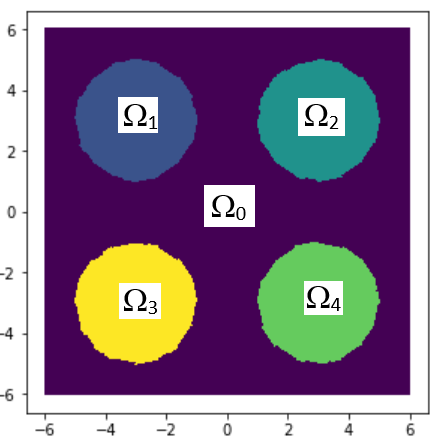

dim(Vh) =  4070
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ab47eec1a204d0f7deb29a73b4525bec0dc6e4d7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           2
  Number of exterior_facet subdomains: 4
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              4
  Coefficients:                        '[f_7907, f_7908, f_7911, f_7912]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elemen

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_beabc89512ddeda679524128dffb5706b5837a1a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_7905, f_7906]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  representa

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3c16163984060105ece1213597a717fab7eacfb4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_7917]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0355017 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------

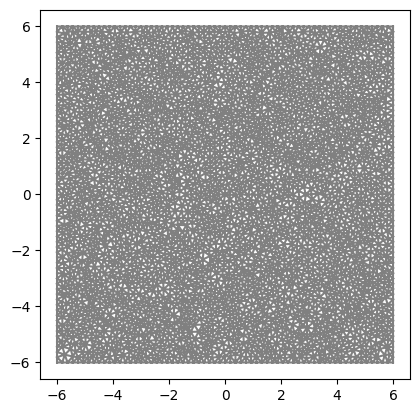

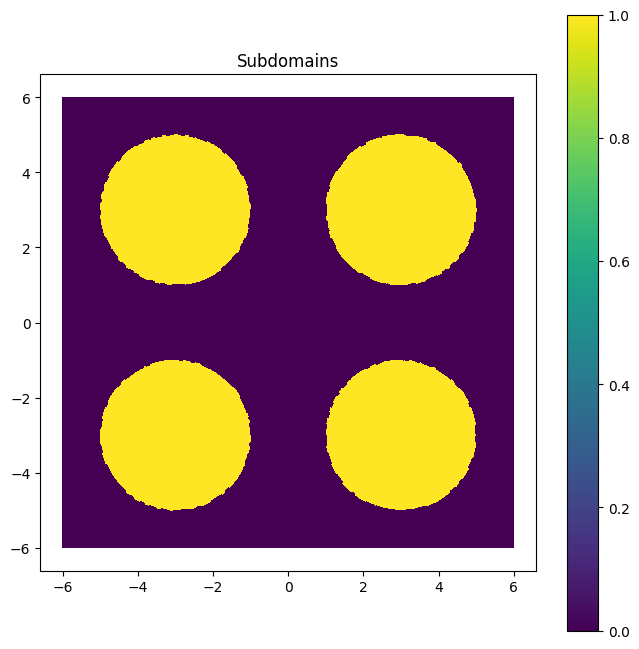

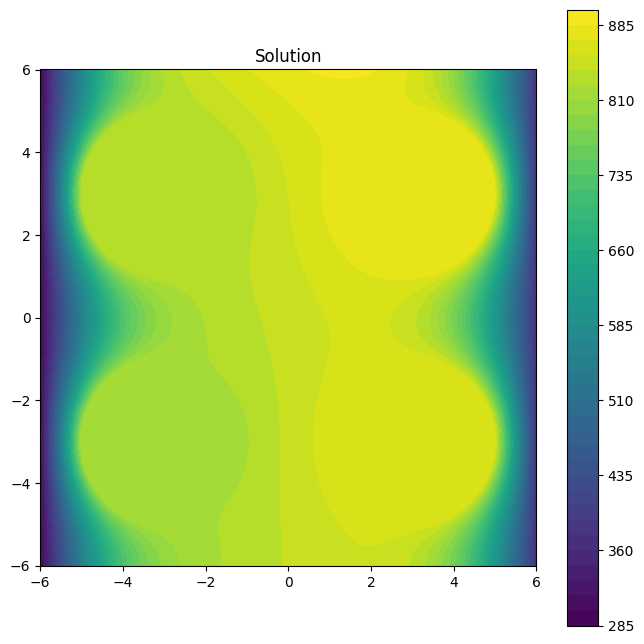

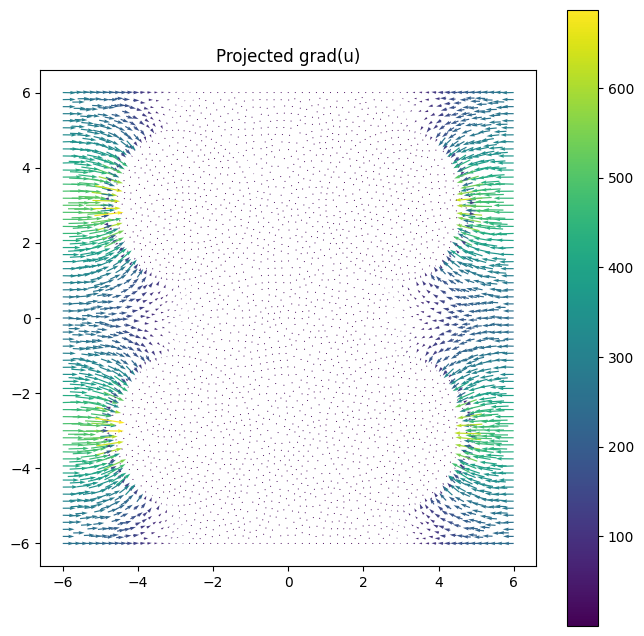

In [57]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

A = Point(-6, -6)
B = Point(6, 6)

domain = Rectangle(A, B)

circ_rad = 2
circ1 = Circle(Point(3.0, 3.0),circ_rad) # top right circle
circ2 = Circle(Point(-3.0, 3.0),circ_rad) # top left circle
circ3 = Circle(Point(3.0, -3.0),circ_rad) # bottom right circle
circ4 = Circle(Point(-3.0, -3.0),circ_rad) # bottom left circle

# Make subdomain from mesh elements

domain.set_subdomain(1, circ1)
domain.set_subdomain(2, circ2)
domain.set_subdomain(3, circ3)
domain.set_subdomain(4, circ4)

# Generate Mesh
mesh = generate_mesh(domain, 50)
plot(mesh)
#
d = 1
Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())

# Define input data
k0 = Constant(0.60)
k1 = Constant(400)
g_B = Constant(0.0)
g_T = Constant(10.0)
T_L = Constant(295.0)
T_R = Constant(375.0)
f   = Constant(0.0)
f1   = Constant(100.0)

#
#  Define Dirichlet boundary condition
#
def Left(x, on_boundary):
  return on_boundary and near(x[0] , -6)

bc_1 = DirichletBC(Vh, T_L, Left)
#
def Right(x, on_boundary):
  return on_boundary and near(x[0] , 6)

bc_2 = DirichletBC(Vh, T_R, Right)
#
bcs = [bc_1, bc_2]

#
# Define subdomains labels
#
class Top_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] - 3)**2 + (x[1] - 3)**2)
    return (r < circ_rad * 1.0001)

class Top_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +3)**2 + (x[1] - 3)**2)
    return (r < circ_rad * 1.0001)

class Bottom_Right_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] -3)**2 + (x[1] + 3)**2)
    return (r < circ_rad * 1.0001)

class Bottom_Left_hole(SubDomain):
  def inside(self, x, on_boundary):
    r = sqrt((x[0] +3)**2 + (x[1] + 3)**2)
    return (r < circ_rad * 1.0001)
#
# Initialize sub-domain instances
top_right_hole = Top_Right_hole()
top_left_hole = Top_Left_hole()
bottom_right_hole = Bottom_Right_hole()
bottom_left_hole = Bottom_Left_hole()
#
# Define subdomains
subdomain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# mark the entire subdomains as 0
subdomain_markers.set_all(0)
#
# Mark the subdomains  1
top_right_hole.mark(subdomain_markers, 1)
top_left_hole.mark(subdomain_markers , 1)
bottom_right_hole.mark(subdomain_markers ,1)
bottom_left_hole.mark(subdomain_markers , 1)

# Plot subdomains
plt.figure(figsize=(8,8))
c = plot(subdomain_markers, title="Subdomains")
plt.colorbar(c)

#
# Define boundary labels
#
class Bottom(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], -6.0)

class Top(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], 6.0)

# Initialize sub-domain instances
top = Top()
bottom = Bottom()
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0
boundaries.set_all(0)
#
# Mark the boundaries 2 and 3
top.mark(boundaries, 2)
bottom.mark(boundaries, 3)

# Define the integration on boundaries and subdomains
#
dx=Measure('dx', domain=mesh, subdomain_data=subdomain_markers)
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational form
u = TrialFunction(Vh)
v = TestFunction(Vh)

a = inner(k0*grad(u), grad(v))*dx(0) + inner(k1*grad(u), grad(v))*dx(1)
L = f*v*dx(0) + f1*v*dx(1) + g_T*v*ds(2) + g_B*v*ds(3)

# Solve problem
u = Function(Vh)
solve(a == L, u, bcs)

# Plot solution
plt.figure(figsize=(8,8))
c = plot(u, title="Solution")
plt.colorbar(c)

plt.figure(figsize=(8,8))
p = plot(grad(u), title="Projected grad(u)")
plt.colorbar(p)

NameError: name 'circle_ex' is not defined

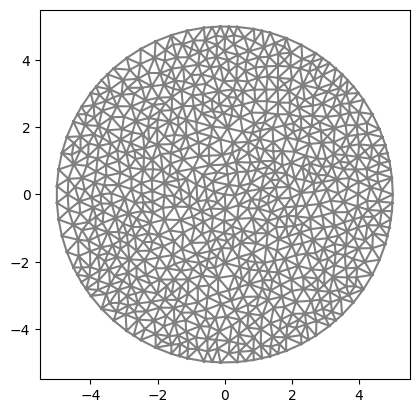

In [58]:
# Import FEniCS
from dolfin import *
from mshr import *
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

r_ex = 5.0
r_in = 3.0

k = Constant(0.935) #conductivity
h = Constant(2.)
T0 = Constant(300.)

domain = Circle(Point(0,0),r_ex)

V = FunctionSpace(mesh, 'P', 2)
#
mesh = generate_mesh(domain, 20)
plot(mesh)

k0 = Constant(300.0)
f0 = Constant(300.0)

k1 = Constant(400.0)
f1 = Constant(400.0)

class Conductor(SubDomain):
    def inside(self, x, on_boundary):
        return (pow(x[1], 2) + pow(x[0],2) - 9) < DOLFIN_EPS

class circle_extern(SubDomain):
  def inside(self, x, on_boundary):
    r1 = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r1 > r_ex*0.9

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary_parts.set_all(0)

circle_ex.mark(boundary_parts,1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

bcs = []

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, 2, mesh.domains())
domains.set_all(0)

conductor = Conductor()
conductor.mark(domains, 1)

p = plot(domains, title="Subdomains")
plt.colorbar(p)

dx = Measure('dx', domain=mesh, subdomain_data=domains)

V0 = FunctionSpace(mesh, 'DG', 0)
class rho(UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] != 0:
            values[0] = k1
        else:
            values[0] = k0

thermal_conductivity = rho(domains, degree=1)

plt.figure(figsize=(6,6))
#plot(mesh, linewidth=0.5)
p = plot(project(thermal_conductivity, V0))
plt.colorbar(p)
plt.show()

V1 = FunctionSpace(mesh, 'DG', 0)
class rho2(UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] != 0:
            values[0] = f1
        else:
            values[0] = f0

thermal_load = rho2(domains, degree=1)

plt.figure(figsize=(6,6))
#plot(mesh, linewidth=0.5)
p = plot(project(thermal_load, V1))
plt.colorbar(p)
plt.show()

u = TrialFunction(V)
v = TestFunction(V)
a = thermal_conductivity*inner(nabla_grad(u), nabla_grad(v))*dx
L = thermal_load*v*dx + T0*v*ds(1)
uh = Function(V)

solve(a == L, uh, bcs=bcs)
#A, b = assemble_system(a, L, bcs=bcs)
#solve(A, uh.vector(), b, "cg")

p = plot(uh)
plt.colorbar(p)
plt.show()


Consider 2D heat transfer across the domain shown in the figure below. Solve the heat transfer problem, with the following boundary conditions:

• The $AB$, $CD$, $EF$, and $GH$ boundaries are insulated. (Neumann boundary condition with the heat flux g = 0 W/m.)

• The $BC$, $DE$, $FG$, and $HA$ boundaries are convecting to 25°C with a heat transfer coefficient of 750 W/(m$^2$°C).

• The internal part of the boundary is convecting is convecting to 100°C with a heat transfer coefficient of 750 W/(m$^2$°C).

In the domain use the following material property:

• The thermal conductivity is 52 W/(m·°C).


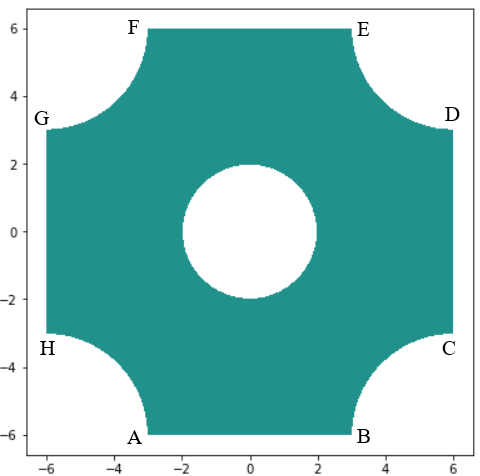

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
#
# to plot the result in the Notebook
%matplotlib inline
#
d = 1
#
domain = Rectangle(Point( -6.0, -6.0 ),Point ( 6.0, 6.0 ) )- Circle(Point(6,6),3) - Circle(Point(-6,6),3) - Circle(Point(-6,-6),3)\
 - Circle(Point(6,-6),3) - Circle(Point(0,0), 2)
mesh = generate_mesh (domain ,50)
Vh  = FunctionSpace(mesh, 'P', 2)
print ("dim(Vh) = ", Vh.dim())

g  = Constant(0.)
h  = Constant(750.0)
T0 = Constant(25.0) # for external shape
T1 = Constant(100.0) # for hole
kappa = Constant(52.)
f = Expression('(x[0] * x[0]) + (x[1] * x[1])', degree=d+2)
#
# Define boundary labels
#
class LeftBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] , -6) and between(x[1] , (-3,3))

class RightBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] - 6.0, 0) and between(x[1] , (-3,3))

class BottomBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1] , -6.0) and between(x[0] , (-3,3))

class TopBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 6.0) and between(x[0] , (-3,3))
#
class Inner_Cercle(SubDomain):
  def inside(self , x , on_boundary):
      r = sqrt((x[0])**2 + (x[1])**2)
      return (on_boundary) and (r < 2 * 1.0001)

class Top_Right_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] -6)**2 + (x[1] - 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Top_Left_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] +6)**2 + (x[1] - 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Bottom_left_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] +6 )**2 + (x[1] + 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Bottom_Right_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] - 6)**2 + (x[1] + 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

leftBoundary = LeftBoundary()
rightBoundary = RightBoundary()
topBoundary = TopBoundary()
bottomBoundary = BottomBoundary()
top_right_hole = Top_Right_hole()
top_Left_hole = Top_Left_hole()
bottom_left_hole = Bottom_left_hole()
bottom_right_hole = Bottom_Right_hole()
inner_Cercle = Inner_Cercle()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#
# mark the entire boundary as 0
#
boundaries.set_all(0)
#
# Mark the isolated parts of the boundaries as subdomains  1
#
rightBoundary.mark(boundaries, 1)
leftBoundary.mark(boundaries, 1)
topBoundary.mark(boundaries, 1)
bottomBoundary.mark(boundaries, 1)
#
# Mark the convective parts of the boundaries as subdomains  2 and 3
#
top_right_hole.mark(boundaries, 2)
top_Left_hole.mark(boundaries, 2)
bottom_right_hole.mark(boundaries, 2)
bottom_left_hole.mark(boundaries, 2)
inner_Cercle.mark(boundaries, 3)
#
#  ds: surface integration
#
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)
#
#  weak form
u = TrialFunction(Vh)
v = TestFunction(Vh)
#
a = kappa*dot(grad(u), grad(v))*dx + h*u*v*ds(2) + h*u*v*ds(3)
L =  f*v*dx + g*v*ds(1) + h*T0*v*ds(2) + h*T1*v*ds(3)
#
uh = Function(Vh)
#
# Solution
solve(a==L, uh)
#
plt.figure(figsize=(8,8))
p = plot(uh)
plt.title('Solution (K)')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar(p)

Consider 2D heat transfer across the domain shown in the figure below. Solve the heat transfer problem, with the following boundary conditions:

• The upper boundary is kept at 50°C. (Dirichlet boundary condition).

• The lower boundary is insulated. (Neumann boundary condition with the heat flux g = 0 W/m.)

• At the left boundary, Neumann boundary condition is considered with the heat flux g = -100 W/m.

• The right boundary is convecting to 20°C with a heat transfer coefficient of 2 W/(m$^2$°C).

In the domain use the following material property:

• The thermal conductivity is 0.935 W/(m·°C).



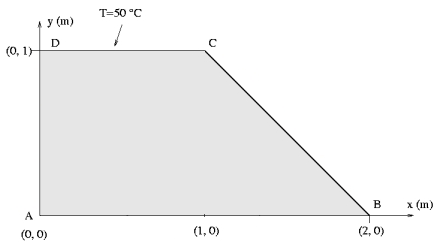


In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
# to plot the result in the Notebook
%matplotlib inline
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)


plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', 2)

k = Constant(0.935)
T0 = Constant(20.)
h = Constant(2.)
u_f = Constant(50.)

g_b = Constant(-100.)
g_0    = Constant(0.)

f = Constant(0.)

#
# Left boundary:  (x = 0 )
#
class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < DOLFIN_EPS
#
# Right boundary:   x + y - 2 = 0
#
class right(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1]+x[0]-2.0, 0.0)
#
# Bottom boundary:  (y = 0 )
#
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]) < DOLFIN_EPS
#
#  Define Dirichlet boundary condition
#
# Top boundary: ( y = 1)
#
def top(x, on_boundary):
    return (x[1] > 1 - DOLFIN_EPS and on_boundary)
#
bc = DirichletBC(Vh, u_f, top)
#
# Define boundary labels
#
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#
# Mark the entire boundary as 0
#
boundary_parts.set_all(0)
#
# Mark the convective parts of the boundaries as subdomains  2, 3 and 4
#
Bottom_p = bottom()
Bottom_p.mark(boundary_parts, 2)
#
Left_p = left()
Left_p.mark(boundary_parts, 3)
#
Right_p = right()
Right_p.mark(boundary_parts, 4)
#
#  ds: surface integration
#
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

u = TrialFunction(Vh)
v = TestFunction(Vh)
a = k*inner(nabla_grad(u), nabla_grad(v))*dx + h*u*v*ds(4)
b = f*v*dx + g_0*v*ds(2) + g_b*v*ds(3) + h*T0*v*ds(4)
#
uh = Function(Vh)
solve(a == b, uh, bc)
#
# Plot solution
#
plt.figure(figsize=(12,8))
c = plot(uh, title="Solution")
plt.colorbar(c)

